In [149]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
import time  # for testing
import pandas as pd # for table

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [150]:
def finDif(omega,f,n,bc):
    """
    Function returning finite different matrix for fourth order difference approximation
    of second order derivative. 
    
    
    info: Given a one dimensional PDE of the form:
    
                            -u''(x) = f(x) , insiede boundary 
                            u(x) = 0 , in boundary
                            
          The function returns a numpy 2d array A and 
          a numpy 1d array b such that:
          
                              A * u = b
        
          where u is the solution vector to the PDE
          problem.
          
    additional: The function uses linear discretization points 
                in the domain of the PDE. 
                
    example:    omega = [0,pi]         # domain interval
                f = lambda x : sin(x)
                n=400                  # discretization points
                bc = [0,0]             # boundary conditions
                
                A, b = finDif(omega, f, n, bc)  # apply function
                u = numpy.linalg.solve(A, b)    # solving linear system
                x = numpy.linspace(omega[0], omega[1], num = numpy.shape(u)[0]) # discretization points
                plot(x, u)  # plotting the solution
                
    """
    
    h = (omega[1] - omega[0]) / ( n - 1 )     # choosing the step size in the interval omega
    x_i = array([i*h for i in range(0,n)])    # discretization points in the interval omega
    b = array(f(x_i))                         # calculating the function at discretization points
    b[0], b[n-1] = bc                         # setting boundary conditions         
    A = diag([-1 for i in range(0,n-2)], -2)  \
    + diag([16 for i in range(0,n-1)], -1)    \
    + diag([-30 for i in range(0,n)])         \
    + diag([16 for i in range(0,n-1)], 1)     \
    + diag([-1 for i in range(0,n-2)], 2)     # creating the A matrix
    return - A / (12*(h**2)), b

Call the function using:

In [178]:
omega = [0,pi]
f = lambda x : sin(x)
n=500
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [152]:
def LU(A, pivoting = False):
    """
    Operating LU factorization on matrix A
    
    info : The function works only for square matrices. By default pivoting is 
           omitted, an exeption is thrown in case pivoting is needed. 
           The function returns the lower triangular matrix (L) and the upper
           triangular matrix (U) as a numpy 2D array. Optionally the permutation
           matrix is return if `pivoting` is set to True.
           
    input : A => numpy 2D array as square matrix 
    
    param : pivoting => boolean :  True => Gauss (partial) pivoting algorithm is performed. 
                                   False => Gauss algorithm is performed.
    
    return: L => numpy 2D array as square matrix representing the lower triangular matrix.
            U => numpy 2D array as square matrix representing the upper triangular matrix.
            
    optional:
            P  => numpy 2D array as square matrix representing the permutation matrix 
                  only if `pivoting` is set to True.
    """
    
    assert(shape(A)[0] == shape(A)[1]), "Invalid Operation, check 'info' by typing  ?LU"
    
    A = array(A, dtype = 'float64')        # convertig to a numpy array
    n = shape(A)[0]                        # number of rows and columns
    P = identity(n)     # permutation matrix
    L = zeros((n, n))  # lower triangular matrix
    
    for k in range(n - 1):
        if(pivoting):                        # pivoting done only if asked by user
            assert( A[k, k] != 0 ), "Division by zero, matrix A not full rank, Gauss decomposition invalid"
            r = k + abs(A[k:, k]).argmax()   # looking at best pivot
            A[[k, r]] = A[[r, k]]            # exchanging rows and columns
            L[[k, r]] = L[[r, k]]            # exchanging rows and columns
            P_now = identity(n)              # inizialization new permutation matrix in step k
            P_now[[k, r]] = P_now[[r, k]]    # exchanging rows and columns
            P = dot(P, P_now)                # updating total permutation matrix
        assert( A[k, k] != 0 ), "Division by zero, use `pivoting = True`"
        L[(k+1):,k] = A[(k+1):,k] / A[k,k]   # taking the L coefficients
        A[k+1:] -= L[k+1:,k][:,None]*A[k,:]  # gauss k-step update of matrix A
        
    fill_diagonal(L, 1) # adding 1 to L matrix diagonal
    
    if(pivoting):
        return L, A, P
    
    return L, A

L, U = LU(A)

In [153]:
def cholesky(A, assumption = True):
    """
    Operating cholesky factorization on matrix A
    
    info : The function works only for symmetric positive definite matrices. 
           The assumptions are checked before performing the operations, 
           optionally by setting `assumption = False` the assumption are 
           not checked, which could result in a gain in performance but 
           results could be wrong (nan or inf numbers).
           
    input : A => numpy 2D array as square matrix 
    
    param : pivoting => boolean :  True => Assumptions for Cholesky factorization are checked. 
                                   False => Assumptions for Cholesky factorization are not checked.
                                   
    return: L => numpy 2D array as square matrix representing the lower cholesky matrix.
            L.tranpose() => numpy 2D array as square matrix representing the upper cholesky matrix.
    """
    
    if(assumption):
        assert( shape(A)[0] == shape(A)[1] ), "Invalid Operation, check 'info' by typing  ?cholesky"
        assert( allclose( A, A.transpose() ) ), "Matrix not symmetric, Cholesky factorization aborted"
        _, U = LU(A, pivoting=False)
        assert(all(diag(U) > 0)), "Matrix not positive definite, Cholesky factorization aborted"
     
    A = array(A, dtype = 'float64')           # converting to numpy array
    L = zeros_like(A)      # initialization L matrix
    
    L[0, 0] = np.sqrt(A[0, 0])
    
    for i in range(1, shape(A)[0]):
        for j in range(i):
            L[j, i] = ( A[i, j] - dot( L[:j, i], L[:j, j] ) ) / L[j, j]
        L[i, i] = sqrt( A[i, i] - dot( L[:i, i], L[:i, i] ) )
    
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [154]:
def L_solve(L,rhs):
    """
    Operating a forward substitutions algorithm to solve a system of linear equation
    for lower triagular matrix.
    
    info : The function works only for lower triangular square matrices. The
           assumption that L is lower triangular is not checked, but checks
           on not null diagonal elements for L are enable.
           
    input : L => numpy 2D array as square lower triangular matrix 
            rhs => numpy 1D array as right hand side of the system
                                   
    return: x => numpy 1D array as solution of the system.
    """
    
    assert(shape(L)[0] == shape(L)[1]), "Invalid Operation: not square matrix, check 'info' by typing  ?L_solve"
    
    L = array(L, dtype = 'float64')          # definition of L
    rhs = array(rhs, dtype = 'float64')      # definition of rhs
    x = zeros_like(rhs, dtype = 'float64')   # definition of x
    
    x[0] = rhs[0] / L[0, 0]
    for i in range(1, L.shape[0]):
        assert(L[i, i] != 0), "Invalid operation, check L is a lower triangular matrix with not null diagonal"
        x[i] = ( rhs[i] - dot(L[i, :i], x[:i] ) ) / L[i, i]
        
    return x

In [155]:
def U_solve(U,rhs):
    """
    Operating a backward substitutions algorithm to solve a system of linear equation
    for upper triagular matrix.
    
    info : The function works only for upper triangular square matrices. The
           assumption that U is upper triangular is not checked, but checks
           on not null diagonal elements for U are enable.
           
    input : U => numpy 2D array as square upper triangular matrix 
            rhs => numpy 1D array as right hand side of the system
                                   
    return: x => numpy 1D array as solution of the system.
    """
    
    assert(shape(U)[0] == shape(U)[1]), "Invalid Operation: not square matrix, check 'info' by typing  ?U_solve"
    
    U = array(U, dtype = 'float64')         # definition of U
    rhs = array(rhs, dtype = 'float64')     # definition of rhs
    x = zeros_like(rhs, dtype = 'float64')  # definition of x
    
    x[U.shape[0] - 1] = rhs[U.shape[0] - 1] / U[U.shape[0] - 1, U.shape[0] - 1]
    for i in range(U.shape[0] -1 , -1, -1):
        assert(U[i, i] != 0), "Invalid operation, check U is a upper triangular matrix with not null diagonal"
        x[i] = ( rhs[i] - dot(U[i, i+1:], x[i+1:]) ) / U[i, i]   
        
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

In [156]:
def solve_system(A, b, pivoting = True):
    """
    Function for solving linear system exploiting LU factorization
    
    info : The function works only for square matrices. The
           assumption that A is square is checked, throwing an
           error otherwise.
           
    input : A => numpy 2D array as square  matrix 
            b => numpy 1D array as right hand side of the system
        
    param : pivoting => boolean :  True => Gauss (partial) pivoting algorithm is performed. 
                                   False => Gauss algorithm is performed.
                      
    return: x => numpy 1D array as solution of the system.
    """
    
    assert(shape(A)[0] == shape(A)[1]), "Invalid Operation, check 'info' by typing  ?solve_system"
    
    if(pivoting):
        L, U, P = LU(A, pivoting)
    else:
        L, U = LU(A, pivoting)
        P = identity(shape(A)[0])
       
    y = L_solve(L, matmul(b,P))
    x = U_solve(U, y)
    
    return x

### Additional

Before continuing let's check if all of the functions previusly implemented work correctly. In function `my_test()` implemented below it is possible to find different tests for the previous functions. The tests are:
* LU factorization without pivoting - function: `LU(*,pivoting = False)`
* LU factorization with pivoting - function: `LU(*,pivoting = True)`
* Cholesky factorization - function `cholesky()`
* Forward  implementation for lower triangular matrix system of equations - function `L_solve()`
* Backward implementation for upper triangular matrix system of equations - function `U_solve()`
* Solving system of linear equation - function `solve_system()`

The test starts by passing at `my_test()` a matrix with the following characteristcs:

* numpy 2D array
* square matrix
* symmetric and positive definite (only for cholesky)

Note that if cholesky assumptions are not fullfilled the test will not be performed and a warning will be throw. Finally, the function can be called by simply typing `my_test()` for launching the default tests. Otherwise, if one wants to check for a specific matrix, simply type:

``` python
A =  np.array([[2, 5, 8], [5, 2, 2], [7, 5, 6]])
my_test(A)
```
Note, this will throw a warning since Cholesky factorization is not possible.

In [157]:
def my_test(A = np.array([[2, 5, 8, 7], [5, 2, 2, 8], [7, 5, 6, 6], [5, 4, 4, 8]])):   
    """
    something to write...
    """
    error = 0
    note = "nada"
    tot = 5
    a = np.random.rand(shape(A)[0])
    
    # Checking if the matrix is square
    assert(shape(A)[0] == shape(A)[1]), "Invalid matrix, use square matrix"
    
    # Checking if the matrix is singular
    L, U, P = LU(A, pivoting=True)
    assert(abs(L.diagonal().prod() * U.diagonal().prod() ) != 0), "Invalid matrix, use not singular matrix"
        
    print("\033[1;30m=========== TEST STARTING ===========\033")
    start_time = time.time()
    # FIRST TEST: LU WITHOUT PIVOTING - function: LU(*,pivoting = False)
    L, U = LU(A, pivoting=False)
    
    try:
        assert(np.allclose(A - L @ U, np.zeros_like(A))), "LU factorization without pivoting failed"
    except AssertionError as e:
        error += 1
        print("FAILED:", e)
    
        
    # SECOND TEST: LU WITH PIVOTING - function: LU(*,pivoting = True)
    L, U, P = LU(A, pivoting=True)
    try:
        assert(np.allclose(A - P @ L @ U, np.zeros_like(A))), "LU factorization with pivoting failed"
    except AssertionError as e:
        error += 1
        print("FAILED:", e)

        
    # THIRD TEST: CHOLESKY FACTORIZATION - function: cholesky()
    if(allclose( A, A.transpose())):
        _, U = LU(A, pivoting=False)
        if(all(diag(U) > 0)):
            HT, H = cholesky(A)
            try:
                assert(np.allclose(A - H @ HT, np.zeros_like(A))), "Cholesky factorization failed"
            except AssertionError as e:
                error += 1
                print("FAILED:", e)
            note = "not"
            tot = 6
             
    # FOURTH TEST: LOWER MATRIX SOLVER - function: L_solve()
    L, U = LU(A, pivoting=False)
    a_L = L_solve(L, a)
    try:
        assert(np.allclose(a - matmul(L, a_L), np.zeros_like(a))), "L_solve() failed in solving linear system"
    except AssertionError as e:
        error += 1
        print("FAILED:", e)
             
    # FIFTH TEST: UPPER MATRIX SOLVER - function: U_solve()
    L, U = LU(A, pivoting=False)
    a_U = U_solve(U, a)
    try:
        assert(np.allclose(a - matmul(U, a_U), np.zeros_like(a))), "U_solve() failed in solving linear system"
    except AssertionError as e:
        error += 1
        print("FAILED:", e)

    # SIXTH TEST: SOLVER LINEAR SYSTEM - function solve_system()
    a_solve = solve_system(A, a)
    try:
        assert(np.allclose(a - matmul(A, a_solve), np.zeros_like(a))), "solve_system() failed in solving linear system"
    except AssertionError as e:
        error += 1
        print("FAILED:", e)
        
    print("")
    print("\033[1;34m TOTAL TIME: %0.3f ms\033" %((time.time()-start_time)* 1000))
    print("\033[1;33m PASSED: %.0f \033[0m" %(tot - error))
    print("\033[1;31m FAILED: %.0f \033[0m" % error)
    if(note == "nada"):
        print("")
        print("\033[1;34m WARNING Cholesky factorization not performed, matrix not symmetric")
    print("")
    print("\033[1;30m============= TEST END ==============\033 \n")

In [158]:
# Here few examples:

# Default test (Warning for cholesky)
my_test()
              
# All tests
A =  np.array([[2, 0], [0, 1]])
my_test(A)


# Singular matrix error
#print("Second test")
#A =  np.array([[2, 1], [2, 1]])
#my_test(A) # error

# Not square matrix error
#print("Second test")
#A =  np.array([[2, 1], [3, 1], [4, 0]])
#my_test(A) # error

=========== TEST STARTING ===========

 TOTAL TIME: 3.719 ms
 PASSED: 5 
 FAILED: 0 

 WARNING Cholesky factorization not performed, matrix not symmetric

============= TEST END ============== 

=========== TEST STARTING ===========

 TOTAL TIME: 2.115 ms
 PASSED: 6 
 FAILED: 0 

============= TEST END ============== 



Nice, no errors! Now thats everything works, let's solve the initial problem

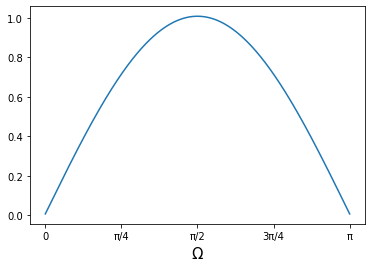

In [159]:
def solve_and_plot(omega,f,n,bc, plotty = True):
    """
    Function for solving and plotting the solution of a finite
    difference problem.
    
    info: Given a one dimensional PDE of the form:
    
                            -u''(x) = f(x) , insiede boundary 
                            u(x) = 0 , in boundary
                            
          The function solves the problem and plot the solution
          
    param: plotty => boolean :  True => Plot of the solution is performed. 
                                False => Plot of the solution is performed.
    
    return: x => numpy 1D array representing discretization points
            f_solve => numpy 1D array representing u(x)
    """
    A, b = finDif(omega, f, n, bc)
    f_solve = solve_system(A, b, pivoting = True)
    x = linspace(omega[0], omega[1], num = shape(f_solve)[0]) # discretization points
    if(plotty):
        plot(x, f_solve)
        xticks(arange(0, 1.1*pi, step=(pi/4)), ['0','π/4', 'π/2','3π/4','π'])
        xlabel("$\Omega$", fontsize=15)
    return x, f_solve

omega = [0,pi]
f = lambda x : sin(x)
n=400
bc = [0,0]
x, f_solve = solve_and_plot(omega,f,n,bc)

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [160]:
def error(omega, f, bc, f_real, plotty=True, max_N = 1200, step = 200):
    """
    Function for plotting the error in resolution of PDE problem
    as a function of discretization point.
    
    info: Given a one dimensional PDE of the form:
    
                            -u''(x) = f(x) , insiede boundary 
                            u(x) = 0 , in boundary
                            
          The function solves the problem using `solve_and_plot()`
          
    param: plotty => boolean :  True => Plot of the solution is performed. 
                                False => Plot of the solution is not performed.
    
    return: pandas dataframe with errors and iterations
    """
    N = np.arange(50,max_N, step)
    error_linf = zeros(shape(N)[0])
    i = 0
    for n in N:
        x, f_solve = solve_and_plot(omega,f,n,bc,plotty=False)
        error_linf[i] = max(abs(f_solve - f_real(x)))
        i+=1
    if(plotty):
        plot(N, error_linf, label = "${\\Vert \\cdot \\Vert}_{\\infty}$")
        xlabel("Iteration", fontsize=15)
        ylabel("Error", fontsize=15, rotation=0, labelpad=20)
        legend()
        yscale('log')
        title("Error vs number of iteartions", fontsize=18)
        grid()
    return pd.DataFrame({'Iteration':N, 'Error l infinity':error_linf})

,Iteration,Error l infinity
0,50,0.001578
1,250,0.000311
2,450,0.000172
3,650,0.000119
4,850,0.000091
5,1050,0.000074


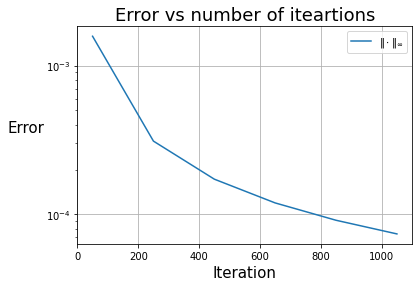

In [129]:
# Time to run ~ 2 mins
omega = [0,1]
bc = [0,0]
f = lambda x : x*(1-x)
f_real = lambda x: np.power(x,4) / 12 - np.power(x,3) / 6 + x / 12
Table = error(omega, f, bc, f_real)
Table

Compute the inverse of the matrix A exploiting the derived LU factorization

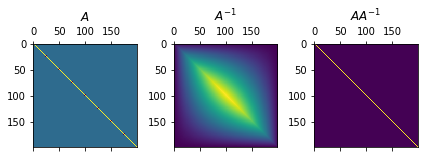

In [161]:
def inverse(A):
    """
    Operating the inverse of a square non singular matrix eploiting LU factorization.
    
    input : A => numpy 2D array as square  matrix 

    return: inv_A => numpy 2D array as inverse of matrix A
    """
    A = array(A, dtype = 'float64')   # defining A matrix 
    inv_A = zeros_like(A)             # defining inverse matrix
    I = identity(shape(A)[0])         # defining identiry matrix
    L, U, P = LU(A, pivoting=True)    # we just do one time LU factorization
    
    for k in range(shape(A)[0]):
        # --- start solving the system using LU --- #
        tmp = L_solve(L, matmul(I[:, k],P))
        inv_A[:, k] = U_solve(U, tmp)
        # --- end solving system using LU --- #
    return inv_A

omega = [0,pi]
f = lambda x : sin(x)
n=200
bc = [0,0]
A, b = finDif(omega, f, n, bc)
A_inv = inverse(A)

# Plotting the results
figure, axes = subplots(nrows=1, ncols=3)
_ = axes[0].matshow(A)
axes[0].title.set_text('$A$')
_ = axes[1].matshow(A_inv)
axes[1].title.set_text('$A^{-1}$')
_ = axes[2].matshow(A.dot(A_inv))
axes[2].title.set_text('$AA^{-1}$')
figure.tight_layout()

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [162]:
def condNumb(A):
    """
    Compute the condition number of a matrix.

    Additional: This function is capable of returning the condition number using 
                the l infinity norm,
    
    input : A => numpy 2D array as square  matrix 

    return: condNu => condition number of matrix A
    """
    A = array(A)
    A_inv = inverse(A)
    condNu = max(sum(abs(A), axis=1))*max(sum(abs(A_inv), axis=1))
    return condNu

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [163]:
def conjugate_gradient(A, b, P = None, nmax=len(A), eps=1e-10, assumption = True):
    """
    Operating conjugate gradient method on a symmetric positive
    definite matrix A.
    
    info : The function works only for symmetric positive definite matrices. 
           The assumptions are checked before performing the operations, 
           optionally by setting `assumption = False` the assumption are 
           not checked, which could result in a gain in performance but 
           results could be wrong (nan or inf numbers).
           
    input : A => numpy 2D array as square matrix 
            b => numpy 1D array as right hand side of the system
            nmax => number of iterations (default = len(A))
            eps => error on each iteration (default 1e-10)
    
    param : asssumption => boolean :  True => Assumptions are checked. 
                                   False => Assumptions are not checked.
                                   
    return: x => numpy 1D array as solver of the system
    """
    
    if(assumption):
        assert( shape(A)[0] == shape(A)[1] ), "Invalid Operation, check 'info' by typing ?conjugate_gradient"
        assert( allclose( A, A.transpose() ) ), "Matrix not symmetric, Conjugate Gradient algorithm aborted"
        _, U = LU(A, pivoting=False)
        assert(all(diag(U) > 0)), "Matrix not positive definite, Conjugate Gradient algorithm aborted"
        
    if P is None:
        P = identity(shape(A)[0])
        
    A = array(A, dtype = 'float64')
    b = array(b, dtype = 'float64')
    
    x = zeros_like(A[0])
    r = b - A.dot(x)
    z = solve_system(P, r)
    p = z
    for k in range(1, nmax):
        if linalg.norm(r) < eps:
            break
            
        alpha = p.dot(r) / A.dot(p).dot(p)
        x += alpha*p
        r -= alpha*A.dot(p)
        z = solve_system(P, r)
        beta = A.dot(p).dot(z) / A.dot(p).dot(p)
        p = z - beta*p
        
    return x

In [164]:
# Small test on conjugate gradient: if everything works correctly no assertion is thrown 
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

assert(np.allclose(conjugate_gradient(A, b) - solve_system(A, b), np.zeros_like(b))), "It doesn't work!!!"

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


#### Solution
We will now solve the time dependent PDE. In general, given a PDE as follow:

$$u'(x,t)=u_{xx}(x,t)+g(x,t) \qquad x \in \Omega = [0, \pi] \;, t \in [0,T],$$

we assume homogeneous Dirichlet boundary conditions $u(x = 0,t) = u(x = \pi,t) = 0$ for any $t > 0$ and initial condition $u(x, t = 0) = u(x)$ for $x \in \Omega$. The function $u(x)$ is the one solving the original problem at $t=0$:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$

$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$
Hence, we discretize the problem as follow:

$$u'(x,t) = \frac{u(x_{n+1}, t_{n+1}) -  u(x_{n}, t_{n})}{h_t} = \frac{-u(x_{n-2}, t_{n})+16u(x_{n-1}, t_{n})-30u(x_{n}, t_{n})+16u(x_{n+1}, t_{n})-u(x_{n+2}, t_{n})}{12h^2} + \alpha(t_n)f(x_n)$$

For what previusly said, it follows:

$$\mathbf{u}(t_{n+1}) = (I - h_tA)\,\mathbf{u}(t_{n}) + h_t\,\alpha(t_n)\,\mathbf{f},$$

where $A$ is the matrix previusly defined above and $I$ is the identity matrix with same dimension as $A$, and $\mathbf{u}(t) = (u(x_1, t), . . . , u(x_N, t))^{T}$, $\mathbf{f} = (f(x_1), . . . , f(x_N))^{T}$

Hence, the problem becomes:
$$
\mathbf{u}(t_{n+1}) = (I - h_tA)\,\mathbf{u}(t_{n}) + h_t\,\alpha(t_n)\,\mathbf{f} \quad t > 0
$$

$$
\mathbf{u}(t_0) = \mathbf{u}(x)
$$


In [240]:
def Forward_Euler(f, alpha, omega, time_omega, Nx, Nt, bc):
    
    h = ( time_omega[1] - time_omega[0] ) / Nt
    t = linspace(time_omega[0], time_omega[1], num = Nt+1, dtype='float64')
    
    u = zeros((Nx, Nt+1))  # first index space, second index time
    
    A, b = finDif(omega, f, Nx, bc)
    x = linspace(omega[0], omega[1], num = shape(b)[0]) # discretization points
    I = identity(shape(A)[0])
    u[:, 0] = solve_system(A, b)
    for k in range(Nt):
        u[:,k+1] = (I - h*A).dot(u[:, k]) + h*alpha(t[k])*b
    
    return u, t, x 
    

Let's see the results

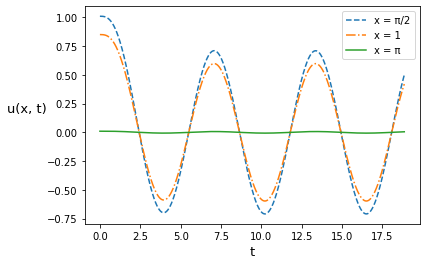

In [245]:
def find_idx(x, s):
    """
    Find the best value in x to approximate the value of s.
    """
    return np.argmin(np.abs(x - s))

time_omega = [0, 6*pi]
omega = [0,pi]
f = lambda x : sin(x)
alpha = lambda x : cos(x)
Nx =300
Nt = 1000000
bc = [0,0]

u, t, x = Forward_Euler(f, alpha, omega, time_omega, Nx, Nt, bc)

# Let's plot
plot(t, u[find_idx(x, pi/2),:], "--", label = "x = π/2")
plot(t, u[find_idx(x, 1),:], "-.", label = "x = 1")
plot(t, u[find_idx(x, pi),:], label = "x = π")
xlabel("t", fontsize=13)
ylabel("u(x, t)", fontsize=13, rotation=0, labelpad=20)
legend()
show()

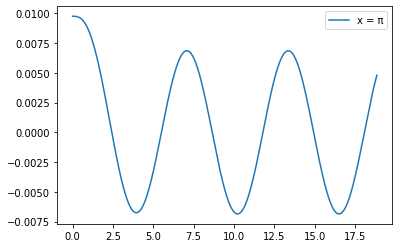

In [249]:
# Very close to zero, as expected
plot(t, u[find_idx(x, pi),:], label = "x = π")
legend()
show()

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

We first write the general power method, then we implement the search of eigenvalues (and eigenvectors) by looking at possible shifts in the Gershgorin circles. In what follows the are three functions:
* `power_method()` => function implmenting the classic power method
* `Build_Gershgorin_circles()` => function for building Gershgorin circles
* `points_in_circles()` => function for finding normally distributed points in a circle
* `Find_eig()` => function for finding eigenvalues and eigenvectors

In [165]:
def power_method(A, shift = 0, tol = 1e-10, MAX_CYCLES = 6000):
    """
    Operating inverse power method
    """
    A = array(A, dtype = 'float64') - shift*identity(shape(A)[0])
    A_inv = inverse(A)
    L, U, P = LU(A, pivoting=True) # we just do one time LU factorization
    x = random.rand(shape(A)[0])
    y = x / linalg.norm(x)
    eigval = 0.
    cycle = 0;
    while(cycle < MAX_CYCLES):
        # --- start solving the system --- #
        tmp = L_solve(L, matmul(y,P))
        x = U_solve(U, tmp)
        # --- end solving system --- #
        y = x / linalg.norm(x) 
        eigval_tmp = 1. / dot(y, matmul( A_inv, y) )  + shift
        if( abs( eigval_tmp - eigval ) < tol ):
            return eigval_tmp, x
                    
        eigval = eigval_tmp
        cycle += 1           
    return eigval, x

def Build_Gershgorin_circles(A):
    """
    Function to calculate Gershgorin circles
    """
    A = array(A, dtype = 'float64')
    circles = []
    circle_centers = diag(A)
    row_radius = sum(A, axis = 1) - diag(A)
    column_radius = sum(A, axis = 0) - diag(A)
    circles = list(zip(circle_centers, row_radius)) + list(zip(circle_centers, column_radius))
    return circles

def points_in_circles(circle, N = 100):
    """
    Operating random uniform points in a 1D circle
    """
    center, radius = circle
    x = random.uniform(center - radius, center + radius, N)
    return x

def Find_eig(A, N = 100, equal_tol = 1e-10):
    """
    Opearting eigenvalue and eigenvector search using power method
    
    info: The following function searches for eigenvalues and eigenvectors
          by using the generalized power method. The shift is computed by 
          looking at random points in the Gershgorin circles.
          
    input: A => numpy 2D array as input matrix
    
    param: N => number of points in Gershgorin circles.
           equal_tol => tolerance for equality in eigenvalues
    
    return: The function returns a tuple. First tuple element `eigval` is a
            numpy 1D array representing all eigenvalues. Second tuple 
            element `eigvect` is a numpy 2D array with eigenvectors as column elements
            ordered with respect to eigenvalues. For istance the column 
            eigvect[:,i] is the eigenvector corresponding to the eigenvalue eigval[i].
    """
    circles = Build_Gershgorin_circles(A)
    eigval = []
    eigvect = []
    for circle in circles:
        for shift in points_in_circles(circle, N):
            eigvalue, eigvector = power_method(A, shift, tol = equal_tol)
            if(len(eigval)== 0):
                eigval.append(eigvalue)
                eigvect.append(eigvector)
            if not any(isclose(eigval, eigvalue, atol=equal_tol*1000, rtol = 0)):
                eigval.append(eigvalue)
                eigvect.append(eigvector)
                
    if len(eigval) > A.shape[0]:
        print("WARNING: Number of found eigenvalues greater than the dimension "
                      "of the matrix, check spurious eigenvalues that "
                      "should be discarded. \n")
        
    if len(eigval) < A.shape[0]:
        print("WARNING: Number of found eigenvalues smaller than the dimension "
                      "of the matrix, some eigenvalues are missing.")
        
    return eigval, eigvect

Here a small test, it takes approximately 42.16 s to run

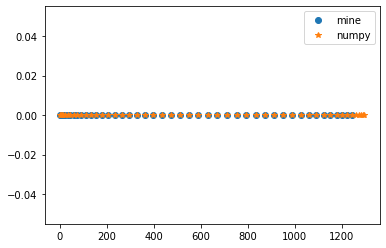

In [142]:
omega = [0,pi]
f = lambda x : sin(x)
n=50
bc = [0,0]
A, b = finDif(omega, f, n, bc)

random.seed(0) 
eigval, eigvect = Find_eig(A, N = 15, equal_tol=1e-12)

# lets's check if everything is correct
eig, _ = linalg.eig(A)

# let's make a plot
plot(sort(unique(eigval)), zeros_like(eigval), 'o', label= "mine")
plot(sort(eig), zeros_like(eig), '*', label= "numpy")
_=legend()

### Additional

It is clear that the power method works correctly and very efficiently, however not all the eigenvalues/ eigenvectors are found. In particular the biggest eigenvalues are not found. One possible solution would be to include more random points in Gershgorin circles, however this can increment extremely the computational cost. Alternatively, for finding the biggest eigenvalue, one could use the directive power method to find the biggest eigenvalue. Another solution is now proposed.

Since A is a symmetric, real and positive definite matrix the QR factorization can be exploit to calculate eigenvalues and eigenvector, as also stated in Chapter 6 of *Alfio Quarteroni, Fausto Saleri, and Paola Gervasio. 2016. Scientific Computing with MATLAB and Octave. Springer Publishing Company, Incorporated" for details*. 

The QR factorization consits in finding a matrix Q orthogonal and R upper triangular matrix. If A is invertible, then the factorization is unique if we require the diagonal elements of R to be positive. The factorization is performed in `QR()` function using the Grand-Shmidt algorithm.

In [166]:
def QR(A):
    """
    Implementing QR factorization
    
    info: The following function implement the QR factorization
          see "Alfio Quarteroni, Fausto Saleri, and Paola Gervasio. 2016. 
               Scientific Computing with MATLAB and Octave. Springer Publishing 
               Company, Incorporated" for details".
               
    input: A => numpy 2D array as input matrix
    
    return: Q => numpy 2D array as orthogonal matrix (QT*Q = 1) 
            R => numpy 2D array as square upper triangular matrix
    """
    A = array(A, dtype = 'float64')
    R = zeros_like(A)
    for j in range(shape(A)[0]):
        R[j, j] = linalg.norm(A[:,j])
        A[:, j] = A[:, j] / R[j, j]
        for k in range(j+1, shape(A)[0]):
            R[j, k] = dot(A[:,j], A[:,k])
            A[:, k] -= A[:,j]*R[j, k]
    return A, R

def eigen(A, MAX_CYCLES = 5000):
    """
    Calculating eigenvalue and eigenvector for symmetric real
    positive definite matrices exploiting QR factorization.
    
    input: A => numpy 2D array as input matrix
    
    param: MAX_CYCLES => max number of iterations before stopping
    
    return: The function returns a tuple. First tuple element `w` is a
            numpy 1D array representing all eigenvalues. Second tuple 
            element `v` is a numpy 2D array with eigenvectors as column elements
            ordered with respect to eigenvalues. For istance the column 
            v[:,i] is the eigenvector corresponding to the eigenvalue w[i].
    """
    Q, R = QR(A)
    S = Q
    A = matmul(R, Q)
    eig = diag(A)
    for _ in range(MAX_CYCLES):
        Q, R = QR(A)
        S = matmul(S, Q)
        A = matmul(R, Q)
            
    return diag(A), S

Here a small test, it takes approximately 33.07 s to run

1.0686562745831907e-11

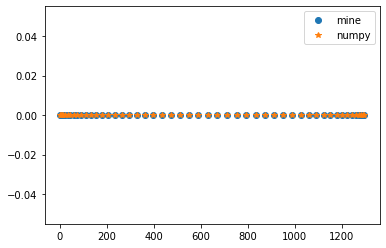

In [144]:
# Original problem
omega = [0,pi]
f = lambda x : sin(x)
n = 50
# n=100 # more points increase the time to 137.38 s and max difference 0.0022
bc = [0,0]
A, b = finDif(omega, f, n, bc)

eigval, eigvect = eigen(A)

# lets's check if everything is correct
eig, _ = linalg.eig(A)

# let's make a plot
plot(sort(unique(eigval)), zeros_like(eigval), 'o', label= "mine")
plot(sort(eig), zeros_like(eig), '*', label= "numpy")
_=legend()

max(sort(eigval) - sort(eig)) # maximum difference between eigenvalues

As we can seen not only all the eigenvalues are found, but the computational time is on the same order as the LU factorization. Finally a remark, this method does not always converge since the matrix has to be symmetric. However, in case of the proposed finite element problem, it provides and efficient solution.



Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [172]:
def Newton(f, Df, x, tol = 1e-10, MAX_ITER = 1000):
    """
    Implementing newton method for zeros search.
    
    info: The following function implement the Newton method
          to search zeros of a function.
               
    input: f => a function for searching its zeros
           Df => a function representing derivative of f
           x => initial poin to search
    
    param: tol => tolerance for stopping criteria
           MAX_ITER => max number of iterations before stopping
           
    return: x => zero of f 
            
    additional: The stop criteria ensures a good approximation
                only if |Df(x)| ~ 1 for every x.
    """
    for _ in range(MAX_ITER):
        x = x - f(x) / Df(x)
        if( abs(f(x)) < tol ):
            return x
    return x

def Backward_Euler(y0, omega, N = 100):
    """
    Solve ordinary differential equation using Backward Euler
    
    info: The program solve ODE of the form:
                        y'(t) = -t*y^2, t in omega
                        y(t = 0) = y0
    
    input: y0 => a function for searching its zeros
           omega => list or numpy 1D array of dimension 2 representing boundary conditions
    
    param: N => number of nodes for Backward Euler

    return: t => time discretization as numpy 1D array
            y => solution of ODE as numpy 1D array
    """
    h = ( omega[1] - omega[0] ) / N
    t = linspace(omega[0], omega[1], num = N+1, dtype='float64')
    y = zeros_like(t)
    y[0] = y0
    
    for k in range(1, N+1):
        f = lambda x : x - y[k-1] + h*t[k]*power(x, 2)
        Df = lambda x : 1 + 2*h*t[k]*x
        y[k] = Newton(f, Df, y[k-1])
        
    return t, y

Since the Cauchy problem is easily solvable by hand, let's plot for 50 nodes the solution we obtain versus the exact solution

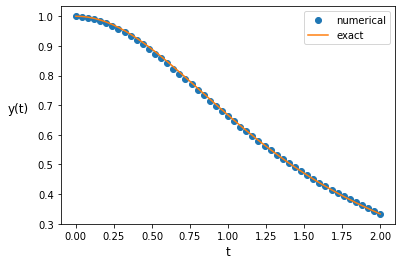

In [170]:
y0=1
omega = [0, 2]
t, y = Backward_Euler(y0, omega, N = 50)
exact = lambda x: 2 / ( power(x, 2) + 2 )

plot(t, y, 'o', label = 'numerical')
plot(t, exact(t), label = 'exact')
legend()
xlabel("t", fontsize=12)
ylabel("y(t)", fontsize=12, rotation=0, labelpad=20)
show()

Here a graph on the max absolute error between numerical and exact solution as the number of nodes increases

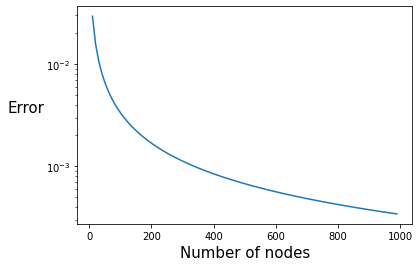

In [171]:
y0=1
omega = [0, 2]
N = [i for i in range(10, 1000, 10)]
err = []
exact = lambda x: 2 / ( power(x, 2) + 2 )
for n in N:
    t, y = Backward_Euler(y0, omega, n)
    err.append(max(abs(exact(t) - y)))
    
plot(N, err)
xlabel("Number of nodes", fontsize=15)
ylabel("Error", fontsize=15, rotation=0, labelpad=20)
yscale('log')
show()